In [ ]:
micromamba activate scvelo_jupyter_new
micromamba run -n scvelo_jupyter_new pip install rds2py
micromamba run -n scvelo_jupyter_new pip install twine
micromamba run -n scvelo_jupyter_new pip install git+https://github.com/furlan-lab/pyviewmaster.git
micromamba run -n scvelo_jupyter_new pip install plotly==5.24.1
micromamba run -n scvelo_jupyter_new pip install colorcet

In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import scvelo as scv
import os
import glob
import pandas as pd
import numpy as np
sc.settings.set_figure_params(dpi=100, facecolor="white")
import socket
from pyviewmaster import *
import seaborn as sns
import colorcet as cc
import plotly.express as px
import matplotlib.pyplot as plt

hostname = socket.gethostname()

if hostname.startswith("gizmo"):
  ROOT_DIR1 = "/fh/fast/furlan_s/datasets/AML/LOR_classifier/cds"
  ROOT_DIR2 = "/fh/fast/furlan_s/grp/data/ddata/BM_data"
else:
  ROOT_DIR1 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/datasets/AML/LOR_classifier/cds"
  ROOT_DIR2 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/experiments/patient_marrows/WC1/cds"


## LOAD SUMMARIZED EXPERIMENT OBJECT IN PYTHON

In [2]:
from rds2py import read_rds
ref =read_rds(ROOT_DIR1+"/240126_Combined_SE_Object.RDS")


In [3]:
coldata = get_coldata_rds_obj(ref)
coldata.set_index = coldata["rownames"]
rowdata = get_rowdata_rds_obj(ref)
rowdata.set_index = rowdata["gene_short_name"]
scounts = get_counts_rds_obj(ref)

In [4]:
rdata = ad.AnnData(scounts)
rdata.obs = coldata
rdata.var = rowdata
rdata.obs_names = coldata.index
rdata.var_names = rowdata.index
rdata.layers["counts"] = rdata.X.copy()

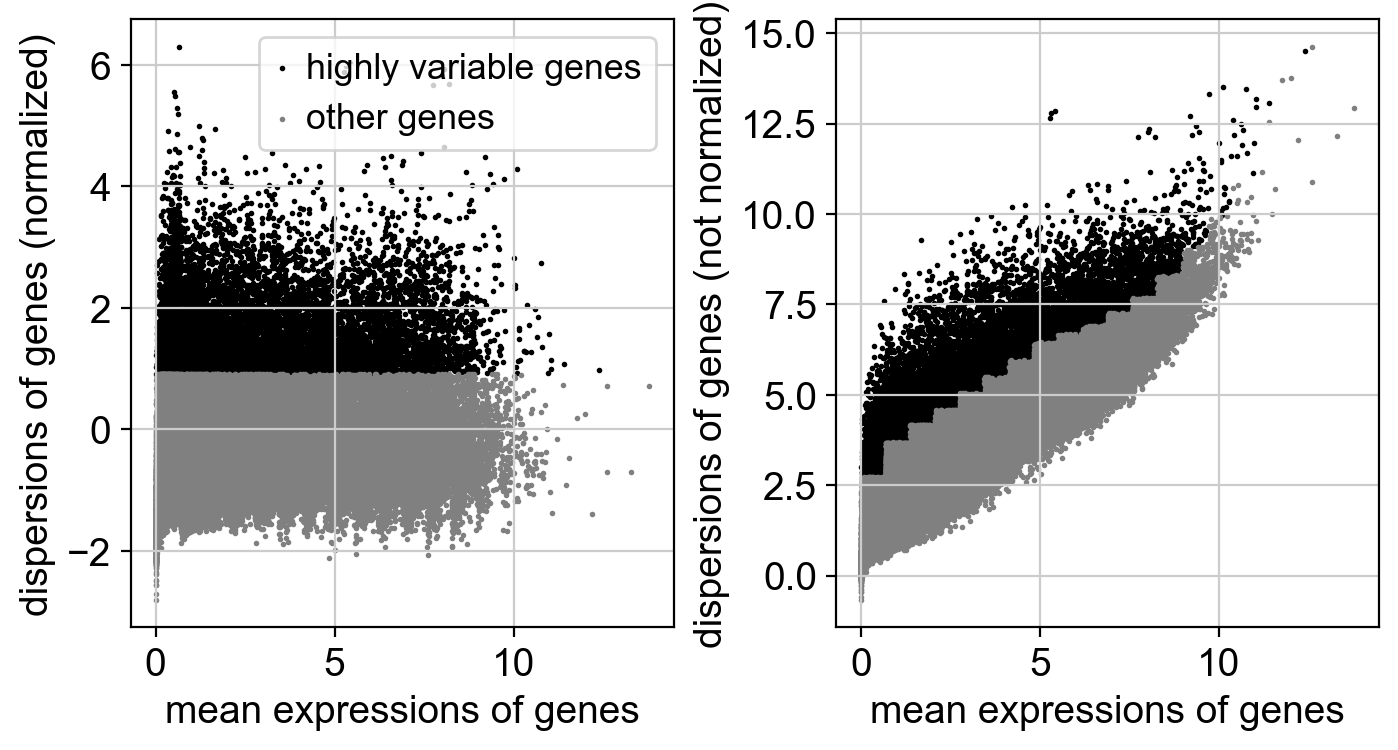

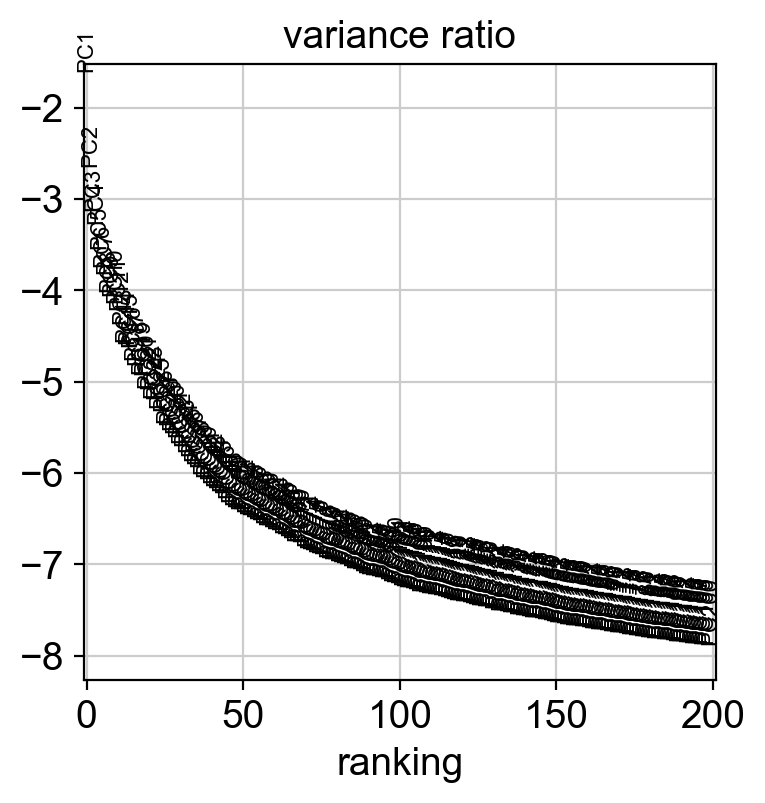

In [5]:
sc.pp.normalize_total(rdata)
sc.pp.log1p(rdata)
sc.pp.highly_variable_genes(rdata, n_top_genes=10000)
sc.pl.highly_variable_genes(rdata)
sc.tl.pca(rdata, n_comps=200)
sc.pl.pca_variance_ratio(rdata, n_pcs=200, log=True)


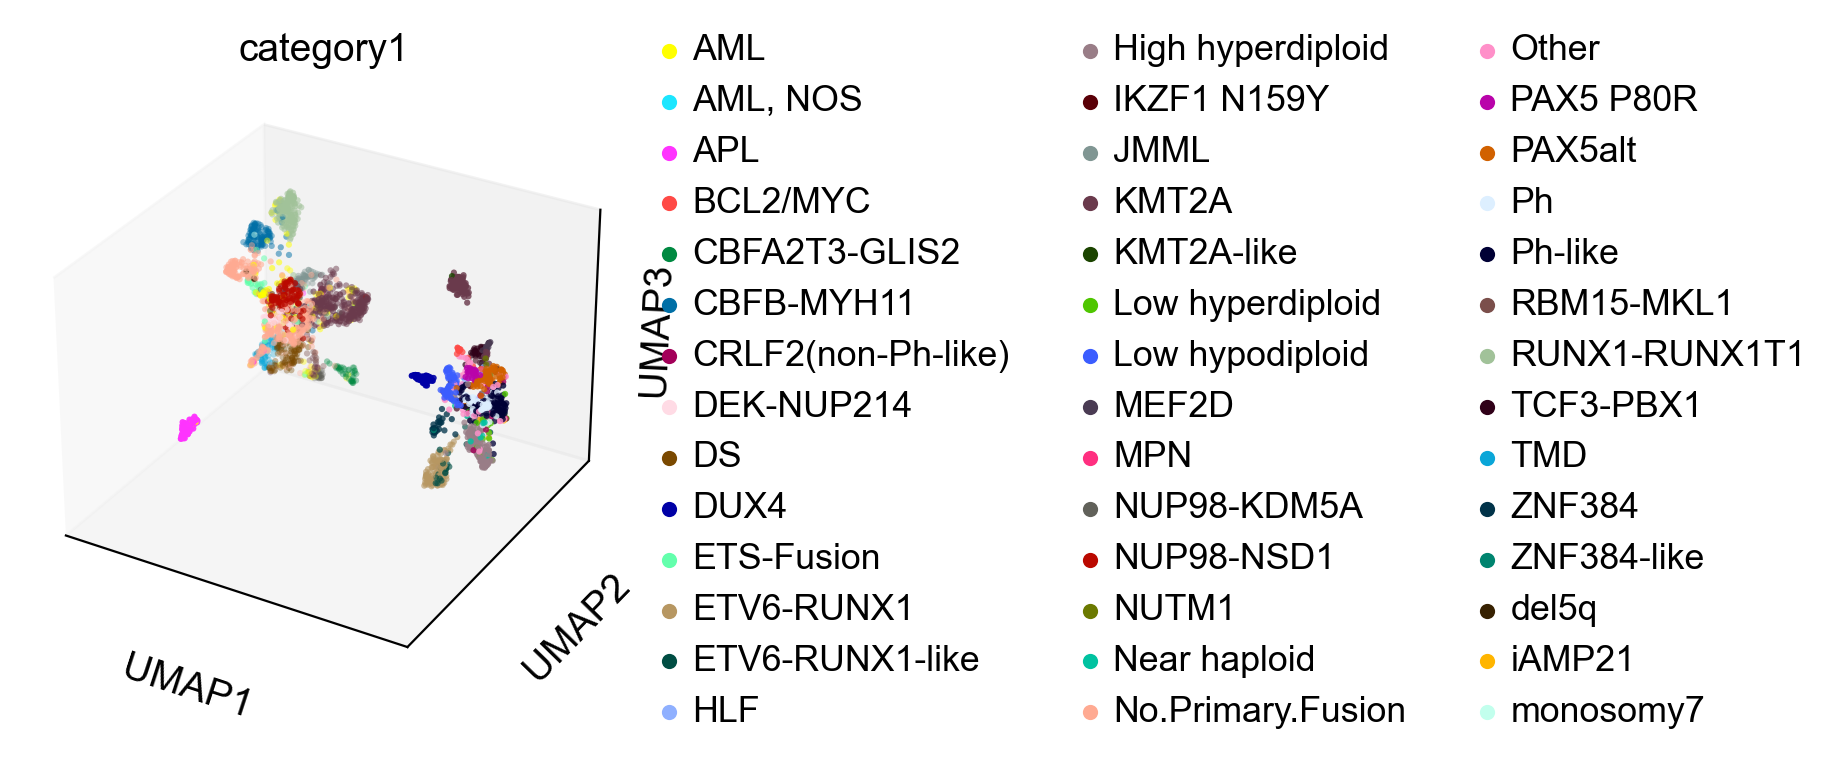

In [6]:
sc.pp.neighbors(rdata, n_pcs=200)
sc.tl.umap(rdata, min_dist=0.4, n_components=3)
sc.pl.umap(rdata, color = "category1", projection = "3d")

In [7]:
palette = sns.color_palette(cc.glasbey, n_colors=50, as_cmap=True)

In [8]:
df = rdata.obsm['X_umap']
df = pd.DataFrame(df)
df.columns = ["umap1", "umap2", "umap3"]
df["category1"] = rdata.obs["category1"].values
df.index = rdata.obs.index
fig = px.scatter_3d(df, x='umap1', y='umap2', z='umap3',
              color='category1', color_discrete_sequence = palette)
fig.update_traces(marker_size = 1.5)
fig.show()


## LOAD QUERY

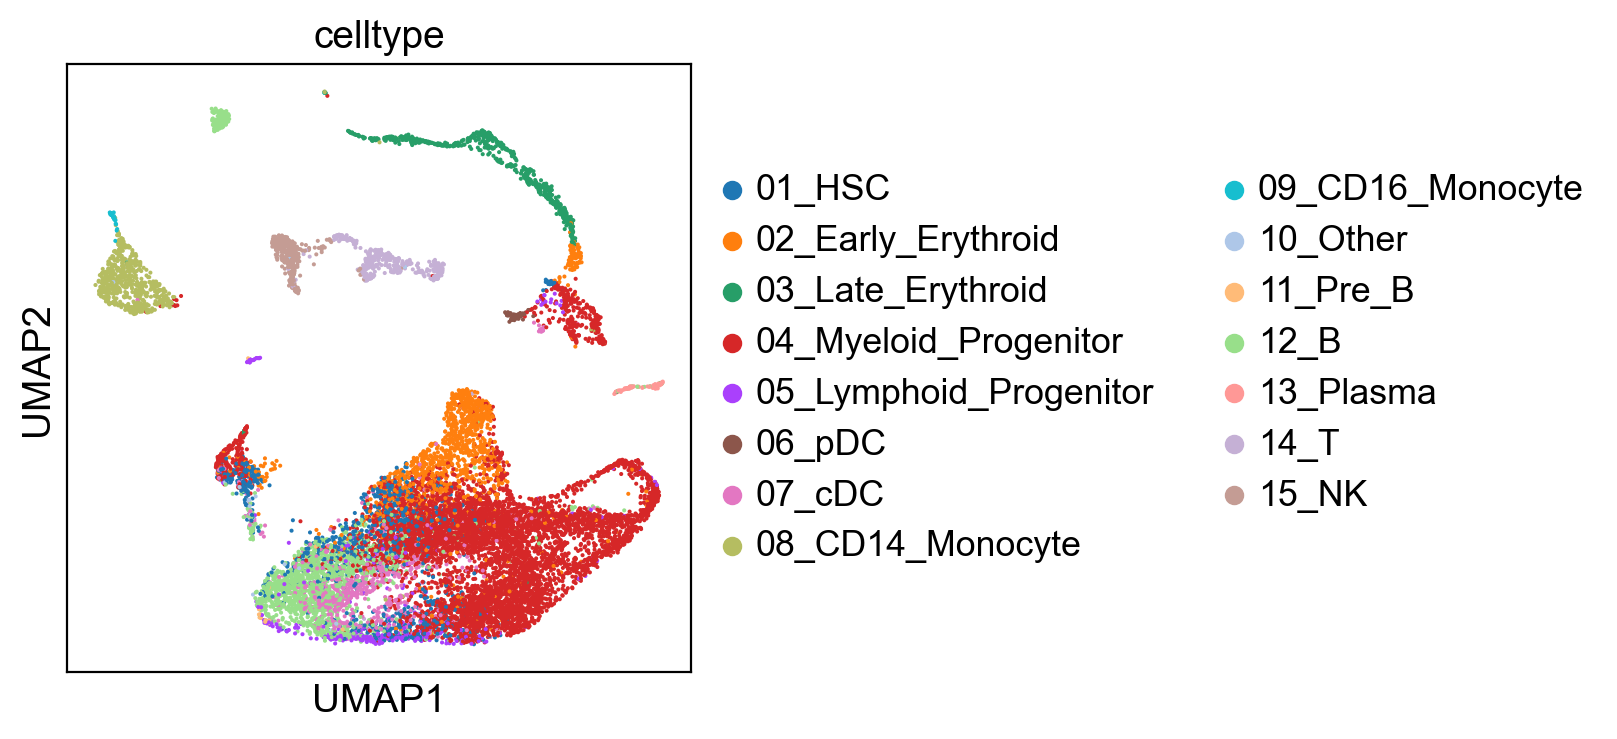

In [9]:
adata = sc.read_loom(ROOT_DIR2+"/WC_velocity.loom")
sc.pl.umap(adata, color = "celltype")


In [10]:
fdata = simulate_single_cells(rdata, adata, 6, "sc-direct", sc_assay_name="matrix")

Finding common features between ref and query
Simulating 6 single cells for every bulk dataset case


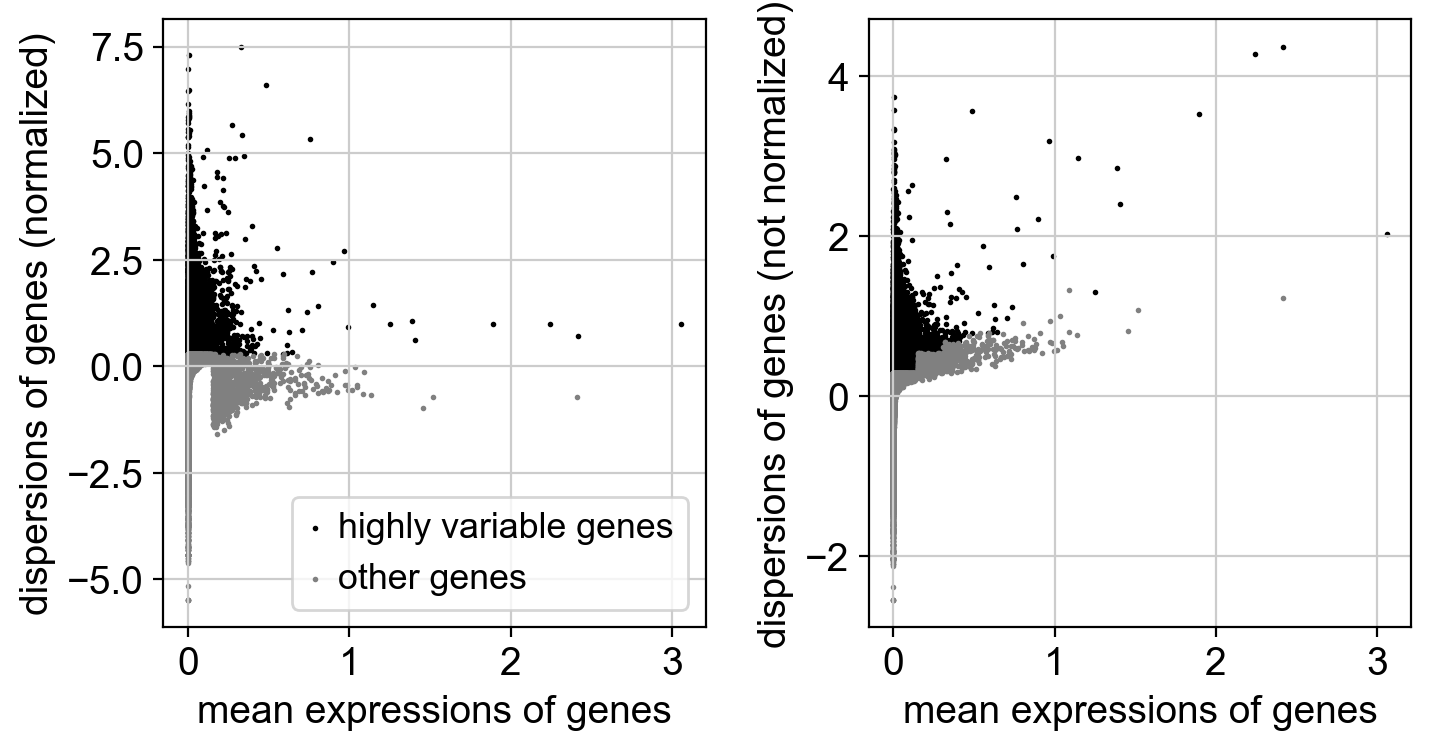

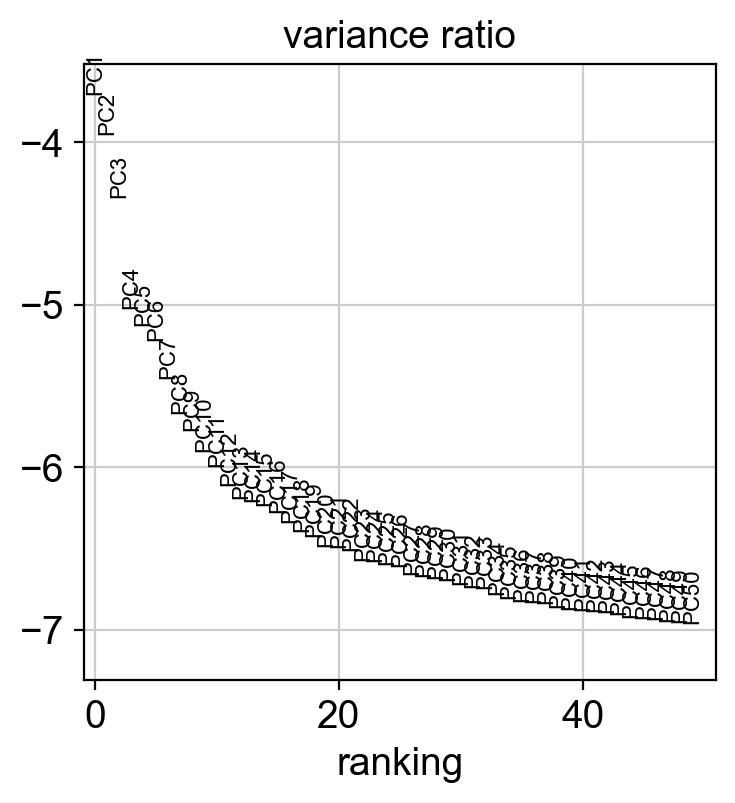

In [11]:
sc.pp.normalize_total(fdata)
sc.pp.log1p(fdata)
sc.pp.highly_variable_genes(fdata, n_top_genes=10000)
sc.pl.highly_variable_genes(fdata)
sc.tl.pca(fdata, n_comps=50)
sc.pl.pca_variance_ratio(fdata, n_pcs=50, log=True)

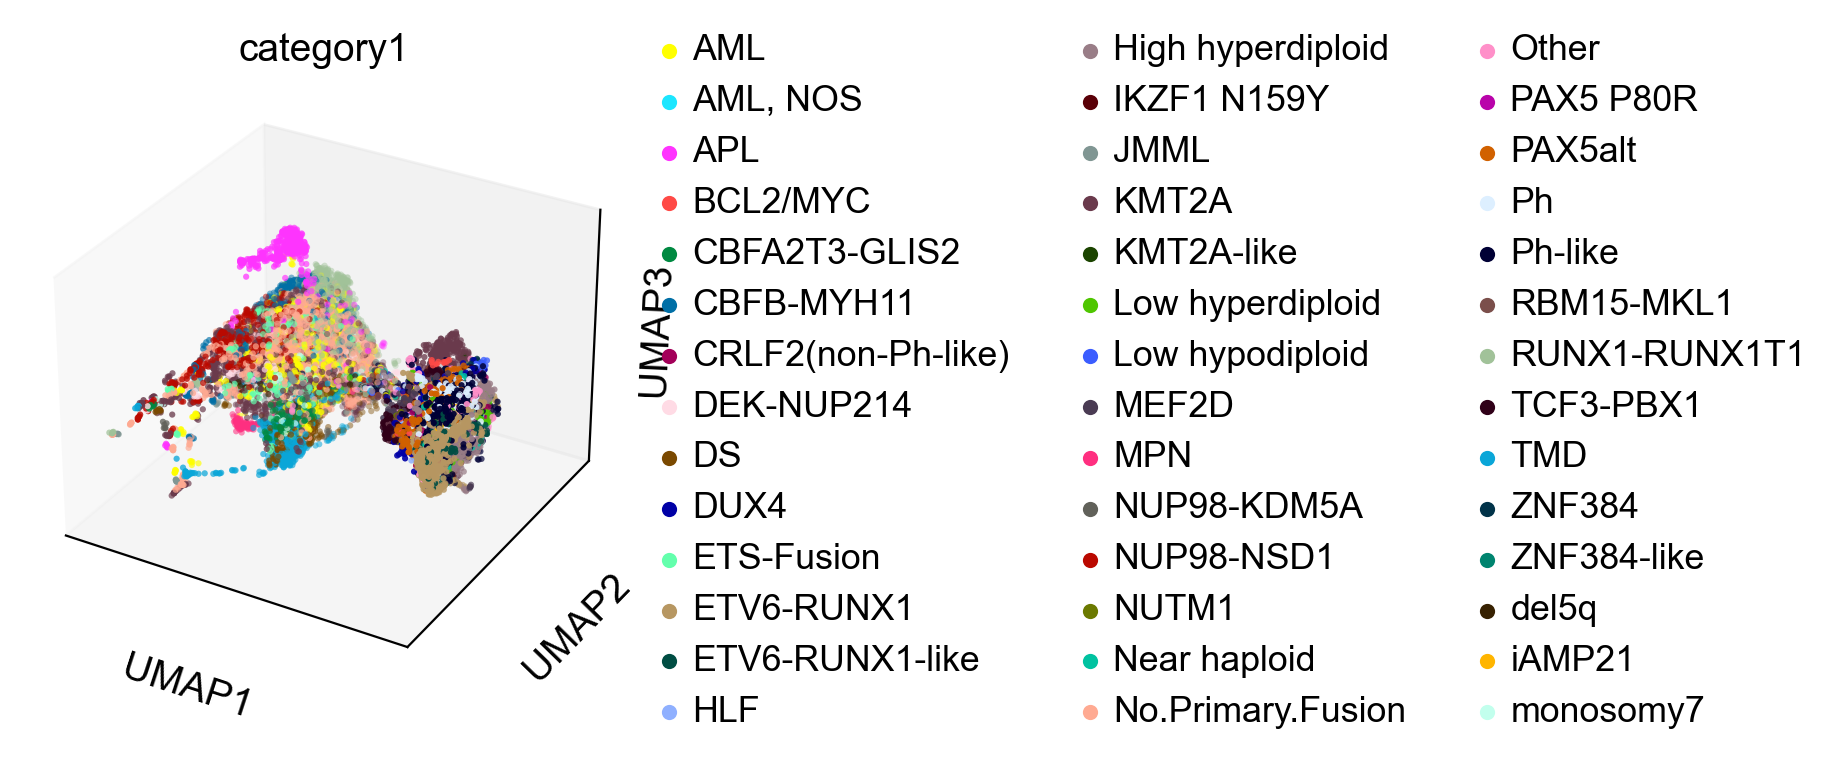

In [13]:
sc.pp.neighbors(fdata, n_pcs=50)
sc.tl.umap(fdata, min_dist=0.4, n_components=3)
sc.pl.umap(fdata, color = "category1", projection = "3d")

In [14]:
viewmaster(query_cds=adata, ref_cds=fdata, ref_celldata_col="category1")

Preparing data...
Normalizing data...
Predictions added to query_cds.obs['viewmaster_pred']


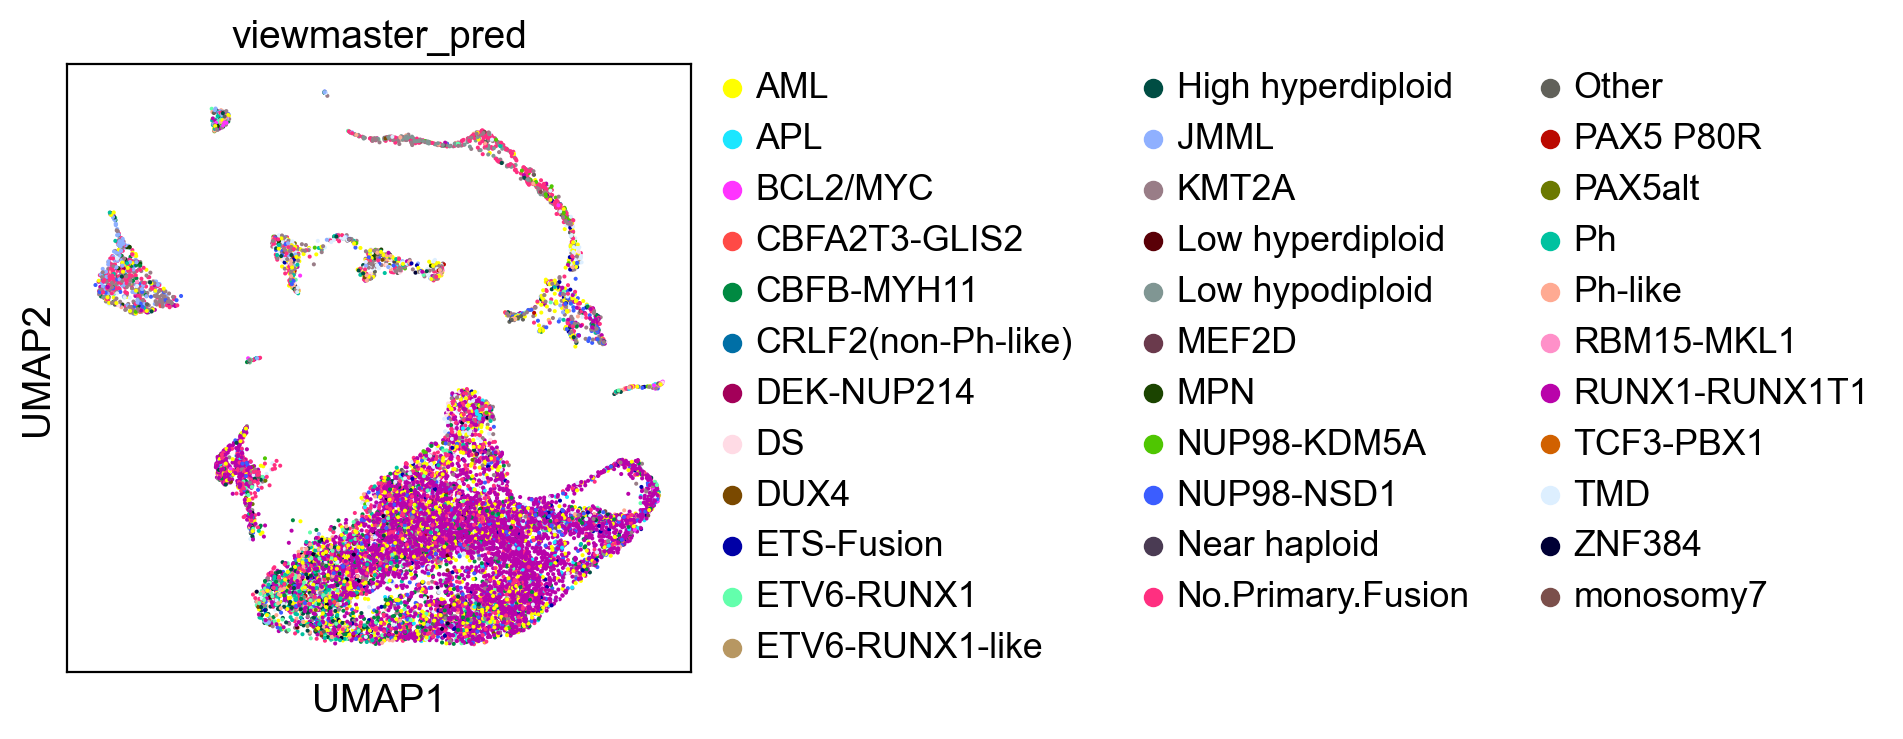

In [16]:
sc.pl.umap(adata, color = "viewmaster_pred")

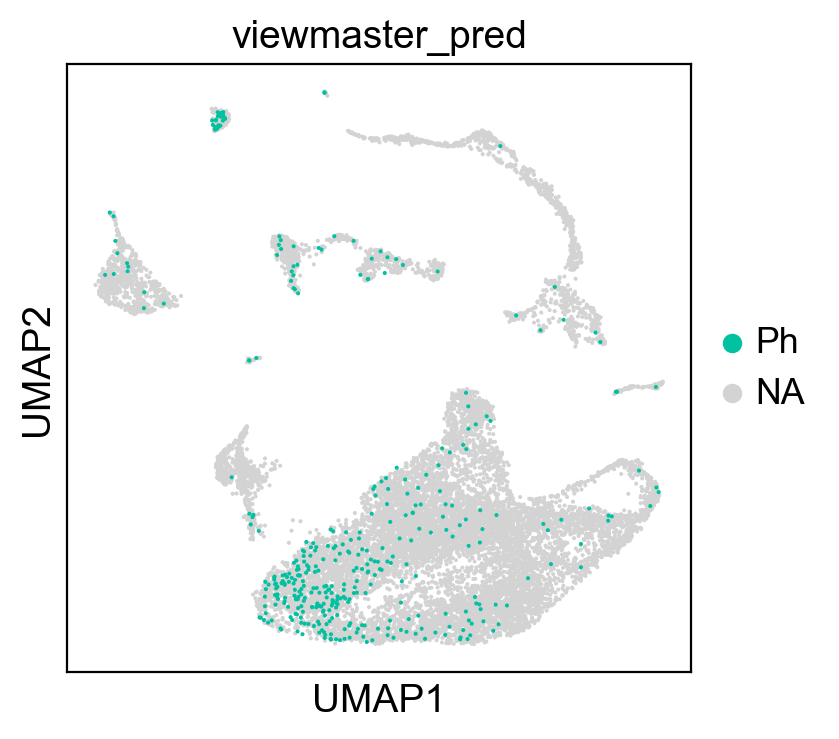

In [19]:
sc.pl.umap(adata, color = "viewmaster_pred", groups = "Ph")

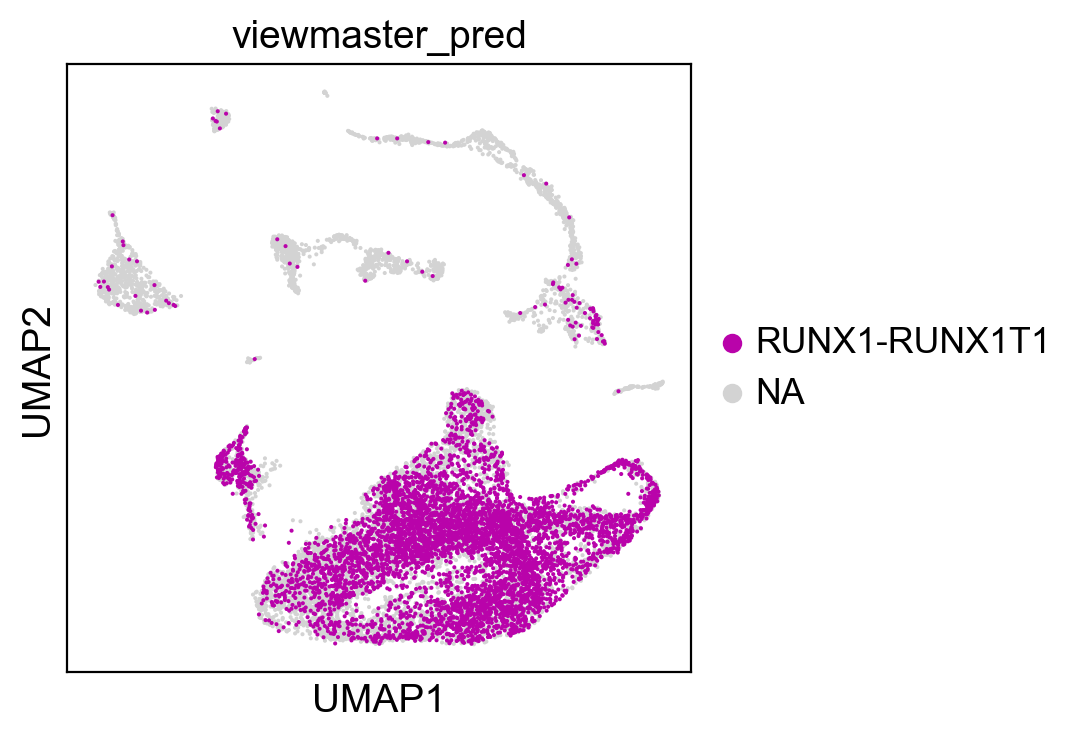

In [20]:
sc.pl.umap(adata, color = "viewmaster_pred", groups = "RUNX1-RUNX1T1")

In [21]:
df = adata.obsm['X_umap']
df = pd.DataFrame(df)
df.columns = ["umap1", "umap2"]
df["viewmaster_pred"] = adata.obs["viewmaster_pred"].values
df.index = adata.obs.index
fig = px.scatter(df, x='umap1', y='umap2',
              color='viewmaster_pred', color_discrete_sequence = palette)
fig.update_traces(marker_size = 1.5)
fig.show()